<div style="width: 100%; overflow: hidden;">
    <a href="https://www.cisuc.uc.pt/groups/show/ecos">
    <div style="float: left;"><img src="https://eden.dei.uc.pt/~naml/images_ecos/ecos.png" width="250px" /></div>
    </a>
    <a href="http://www.uc.pt/fctuc/dei/">
    <div style="float: right;"><img src="https://eden.dei.uc.pt/~naml/images_ecos/dei25.png" width="700px" /></div>
    </a>
</div>

In [1]:
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import requests
import io
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams['axes.grid'] = True
plt.style.use('fivethirtyeight')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 3

In [2]:
def load_timeseries(name):
    base_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
    url = f'{base_url}/time_series_covid19_{name}.csv'
    df = pd.read_csv(url, 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = pd.concat([df, 
                    (df.loc[~df.state.isna()]
                     .groupby(['country', 'date', 'type'])
                     .sum()
                     .rename(index=lambda x: x+' (total)', level=0)
                     .reset_index(level=['country', 'type']))
                   ])
    return df
df_confirmed = load_timeseries('confirmed_global')
populations = pd.read_csv("world-populations.csv", sep=";")
populations = populations.set_index("Country")

In [3]:
df_by_countries = df_confirmed.loc[(df_confirmed["country"] == "Portugal") 
                                   | (df_confirmed["country"] == "Italy") 
                                   | (df_confirmed["country"] == "Spain") 
                                   | (df_confirmed["country"] == "US") 
                                   | (df_confirmed["country"] == "Sweden")
                                   | (df_confirmed["country"] == "Germany")
                                   | (df_confirmed["country"] == "Brazil")]

In [4]:
df_by_countries = df_by_countries.drop(["state"], axis=1)

# Number of confirmed cases over time

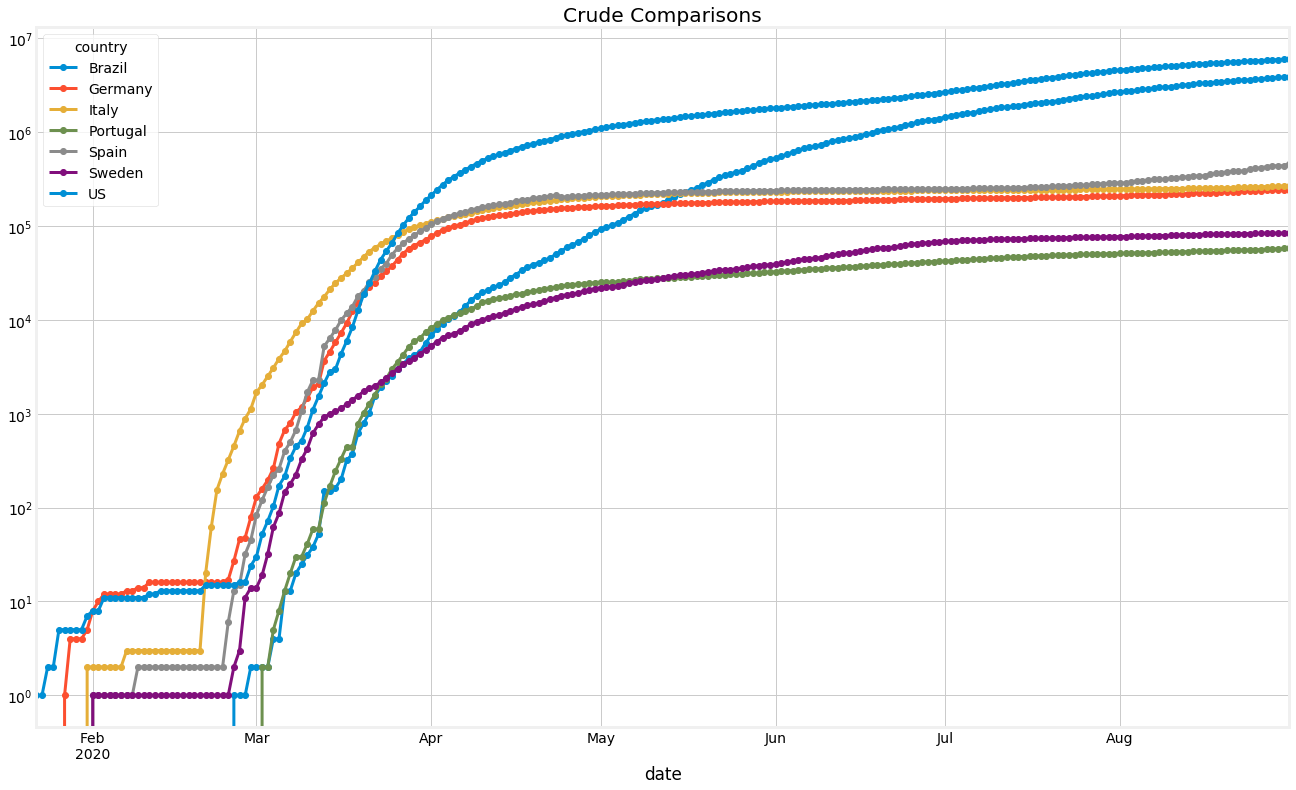

In [5]:
df_by_countries.pivot(columns="country", values="cases").plot(style='o-', title="Crude Comparisons", figsize=(20,12), logy=True)

Text(0, 0.5, '#Cases')

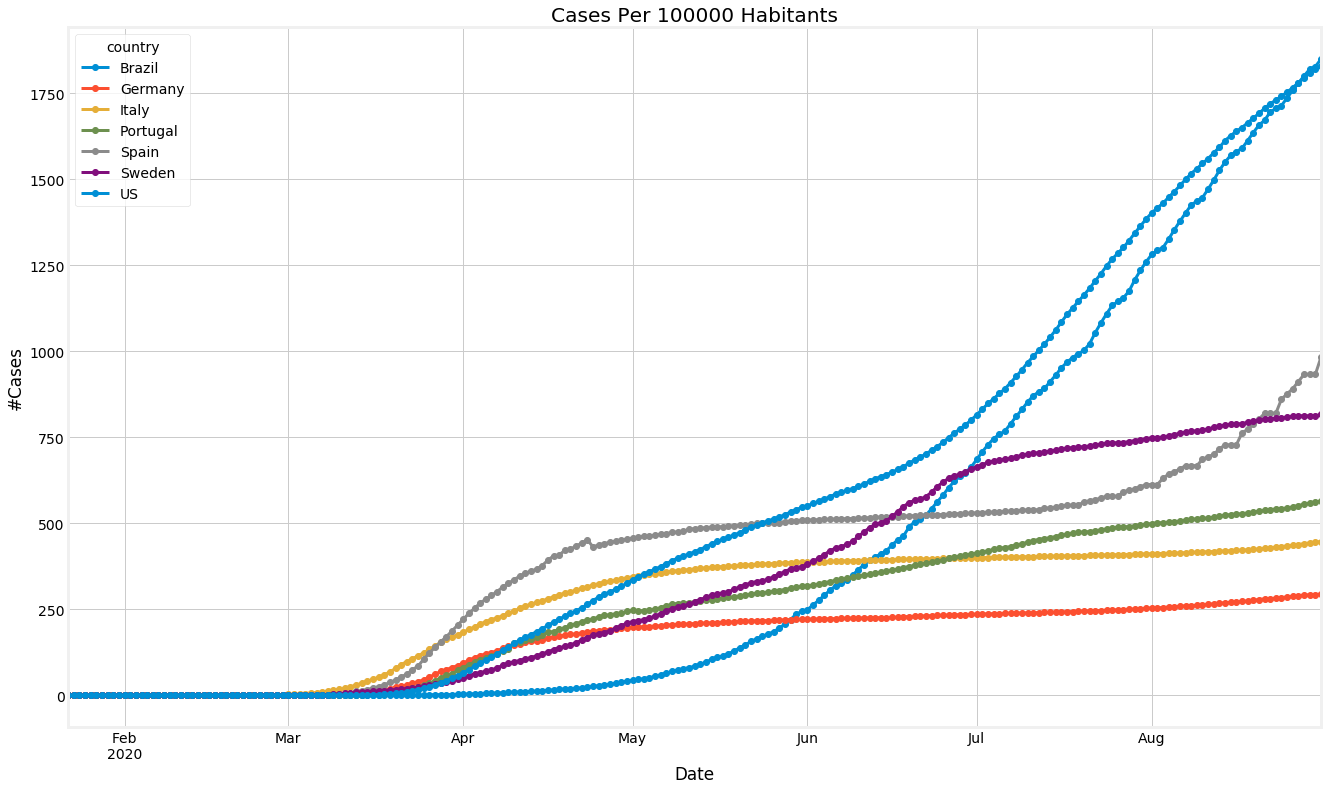

In [6]:
cases_per_capita = df_by_countries.pivot(columns="country", values="cases")
for country in cases_per_capita.columns:
      cases_per_capita.loc[:,country] = (cases_per_capita.loc[:,country] / populations.loc[country]["Population"]) * 10**5
ax = cases_per_capita.plot(style='o-', title="Cases Per 100000 Habitants", figsize=(20,12))
ax.set_xlabel("Date")
ax.set_ylabel("#Cases")

In [7]:
df_100 = df_by_countries[df_by_countries['cases'] > 100].pivot(columns="country", values="cases")
df_100 = df_100.reset_index()

In [8]:
df = df_100.apply(lambda x: pd.Series(x.dropna().values))

# Comparisons after the 100th Case

The graph shows the evolution of the confirmed cases after the 100th case. Log scale is used to make reading easier.

Text(0, 0.5, '#Cases')

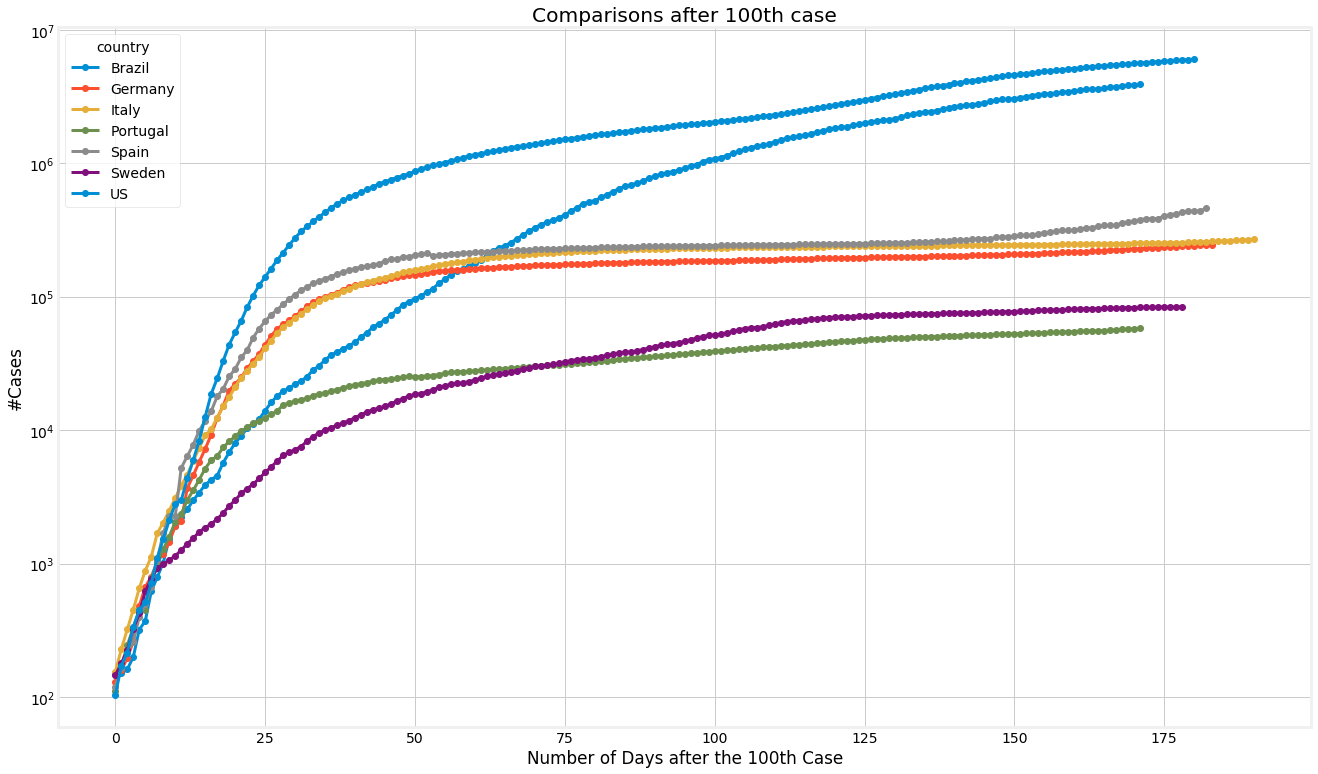

In [9]:
ax = df.drop("date", axis=1).plot(style='o-',title="Comparisons after 100th case", figsize=(20,12), logy=True)
ax.set_xlabel("Number of Days after the 100th Case")
ax.set_ylabel("#Cases")

Text(0, 0.5, '#Cases')

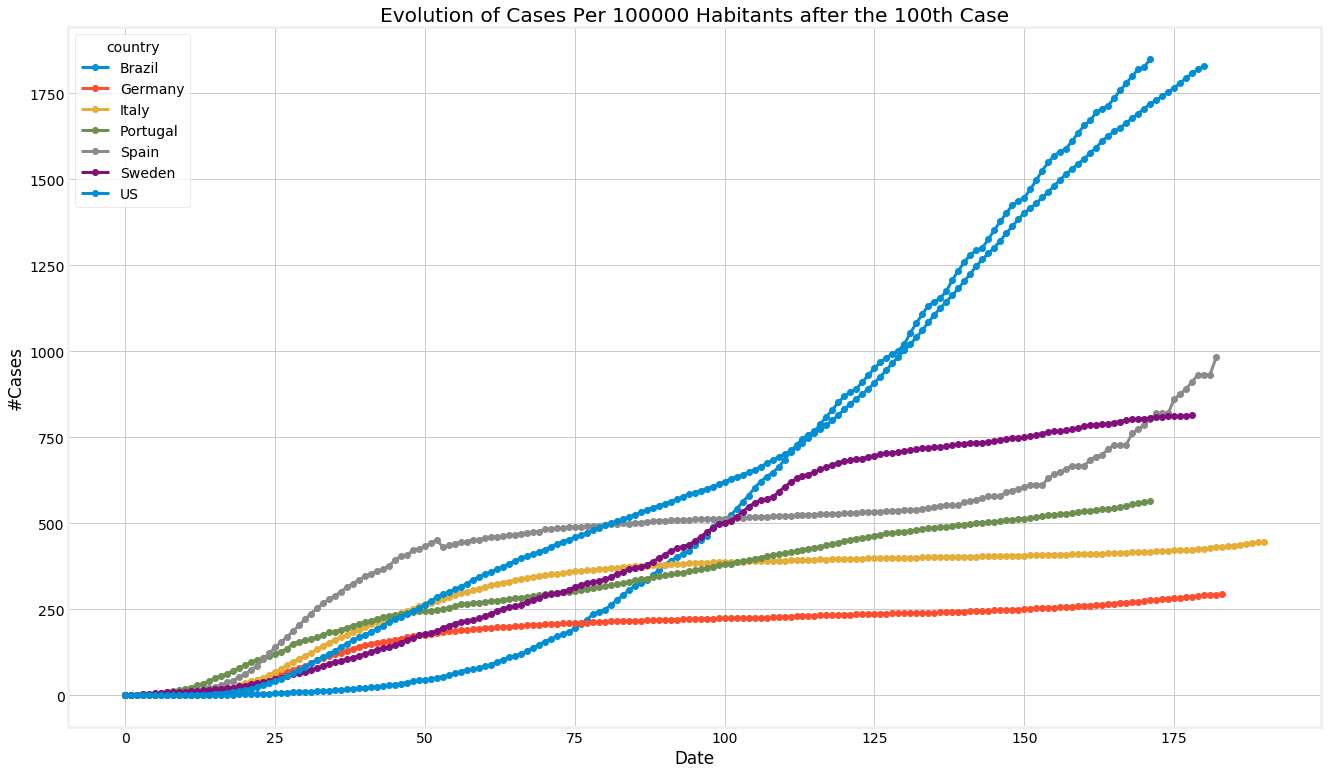

In [10]:
df_100_per_capita = df.copy()
df_100_per_capita.drop("date", axis=1, inplace=True)
for country in df_100_per_capita.columns:
      df_100_per_capita.loc[:,country] = (df_100_per_capita.loc[:,country] / populations.loc[country]["Population"]) * 10**5
ax = df_100_per_capita.plot(style='o-', title="Evolution of Cases Per 100000 Habitants after the 100th Case", figsize=(20,12))
ax.set_xlabel("Date")
ax.set_ylabel("#Cases")

# Predictions for Portugal

In the next few cells I am going to make predictions about the evolution of the confirmed case in Portugal. I am going use a logistic growth and a polynomial fitting. These predictions will be compared with the oberved data.

In [11]:
df_portugal = df_by_countries.pivot(columns="country", values="cases")['Portugal']
df_portugal = df_portugal[df_portugal>0].to_frame()

In [12]:
def logistic_prediction(observed_data, n_points_to_predict=None, seed=4.66, r=0.33):
    if n_points_to_predict is None:
        n_points_to_predict = observed_data.size
    MaxNumberOfCases = 100000
    predicted = np.zeros(n_points_to_predict)
    predicted[0] = seed
    for i in range(1, predicted.size):
        predicted[i] = predicted[i - 1] + predicted[i - 1] * r * (1 - (predicted[i - 1] / MaxNumberOfCases))
    return predicted

In [13]:
def polynomial_fitting(observed_data, n_points_to_predict=None, degree=5, poly=None):
    if n_points_to_predict is None:
        n_points_to_predict = observed_data.size
    x_observed = np.arange(observed_data.size)
    if poly is None:
        poly = np.polyfit(x_observed, observed_data, degree)
    print(poly)
    x_predicted = np.arange(n_points_to_predict)
    predicted = np.polyval(poly, x_predicted)
    return predicted
    

[336.36566659 755.40740081]


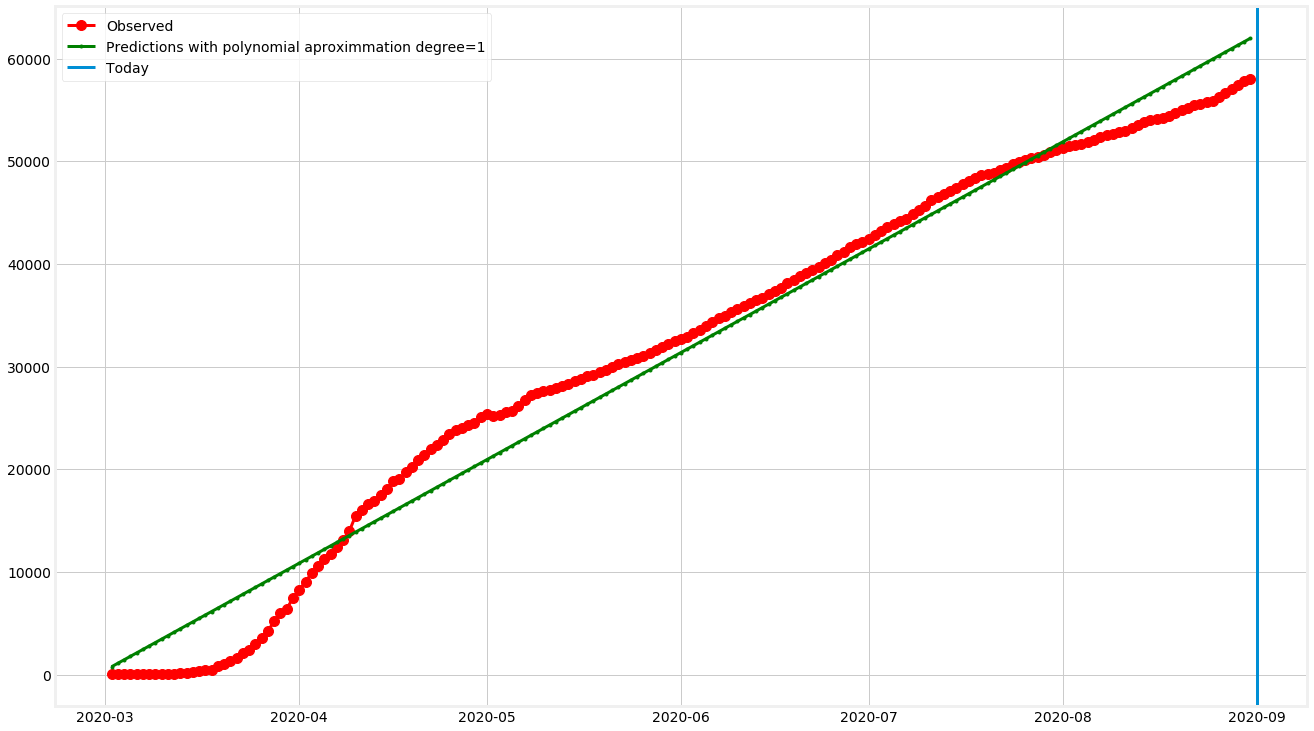

In [19]:
observed_data = df_portugal['Portugal'].values
degree = 1
poly = None #np.array([-1.26310750e-02, 1.31524815e+00, -2.29339937e+01, 1.23975455e+02,
# -1.15565508e+02]) #polynomial of degree 4
n_predictions = None
predicted = polynomial_fitting(observed_data, degree=degree, n_points_to_predict=n_predictions,poly=poly)
dates = df_portugal['Portugal'].index.values
while dates.size < predicted.size:
    dates = np.append(dates, np.array([dates[-1] + np.timedelta64(1, 'D')]))
#plot
plt.figure(figsize=(20,12))
plt.plot(df_portugal['Portugal'].index.values, observed_data, 'ro-',label="Observed", markersize=10)
plt.plot(dates, predicted,'g.-', label="Predictions with polynomial aproximmation degree=%d" % degree)
plt.axvline(x=np.datetime64('today'), label='Today')
plt.legend()

# How the number of cases in Portugal has grown? How does it compare with other countries?

In [20]:
previous = df_portugal['Portugal'].values
next_day = df_portugal['Portugal'].values
increased = (next_day[1:] - previous[:-1]) / previous[:-1]

Text(0.5, 1.0, 'Growth of Confirmed Cased')

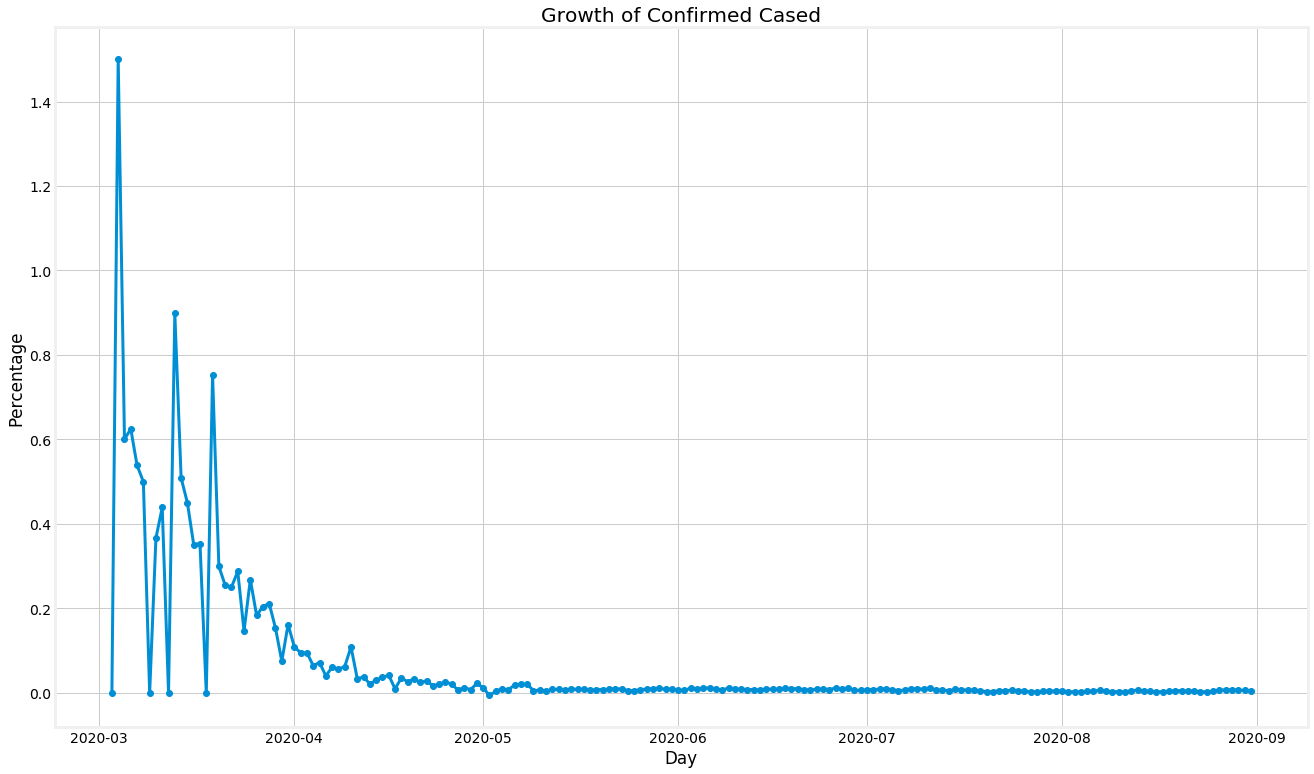

In [21]:
plt.plot(df_portugal['Portugal'].index[1:], increased, 'o-');
plt.xlabel("Day")
plt.ylabel('Percentage')
plt.title("Growth of Confirmed Cased")


In [22]:
df_100.values[:,1:].shape

(191, 7)

In [23]:
previous = df_100.values[:,1:]
next_day = df_100.values[:,1:]
increased = (next_day[1:] - previous[:-1]) / previous[:-1]

In [24]:
increased
index=df_100.date[1:]
df_100.columns

Index(['date', 'Brazil', 'Germany', 'Italy', 'Portugal', 'Spain', 'Sweden',
       'US'],
      dtype='object', name='country')

## Comparison with other countries

Text(0.5, 0, 'Date')

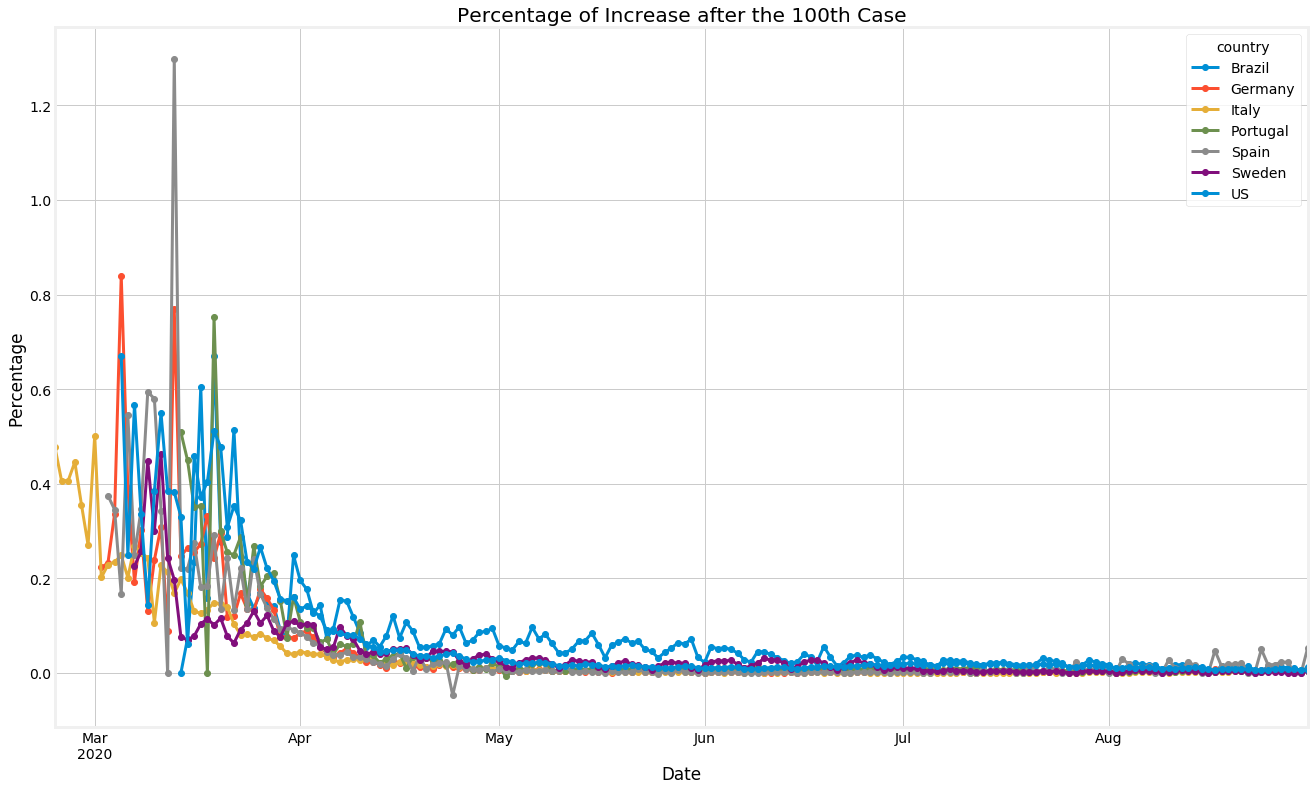

In [25]:
percentage_increase_by_country = pd.DataFrame(columns=df_100.columns[1:], data=increased, index=df_100.date[1:])
ax = percentage_increase_by_country.plot(style="o-")
ax.set_title("Percentage of Increase after the 100th Case")
ax.set_ylabel("Percentage")
ax.set_xlabel("Date")


# Evolution of the number of deaths by country

The graph bellow show the number of deaths by country, after the first confirmed death.

In [26]:
df_deaths_global = load_timeseries('deaths_global')

In [27]:
total_deaths = 100
df_deaths_by_country = df_deaths_global.loc[(df_confirmed["country"] == "Portugal") 
                                   | (df_confirmed["country"] == "Italy") 
                                   | (df_confirmed["country"] == "Spain") 
                                   | (df_confirmed["country"] == "US") 
                                   | (df_confirmed["country"] == "Sweden")
                                   | (df_confirmed["country"] == "Germany")
                                   | (df_confirmed["country"] == "Brazil")]
df_deaths_by_country = df_deaths_by_country[df_deaths_by_country['cases'] > total_deaths].pivot(columns="country", values="cases")
df_deaths_by_country = df_deaths_by_country.reset_index()
df_deaths_by_country = df_deaths_by_country.apply(lambda x: pd.Series(x.dropna().values))

Text(0.5, 1.0, 'Evolution of the Death cases after the 100 Confirmed Death')

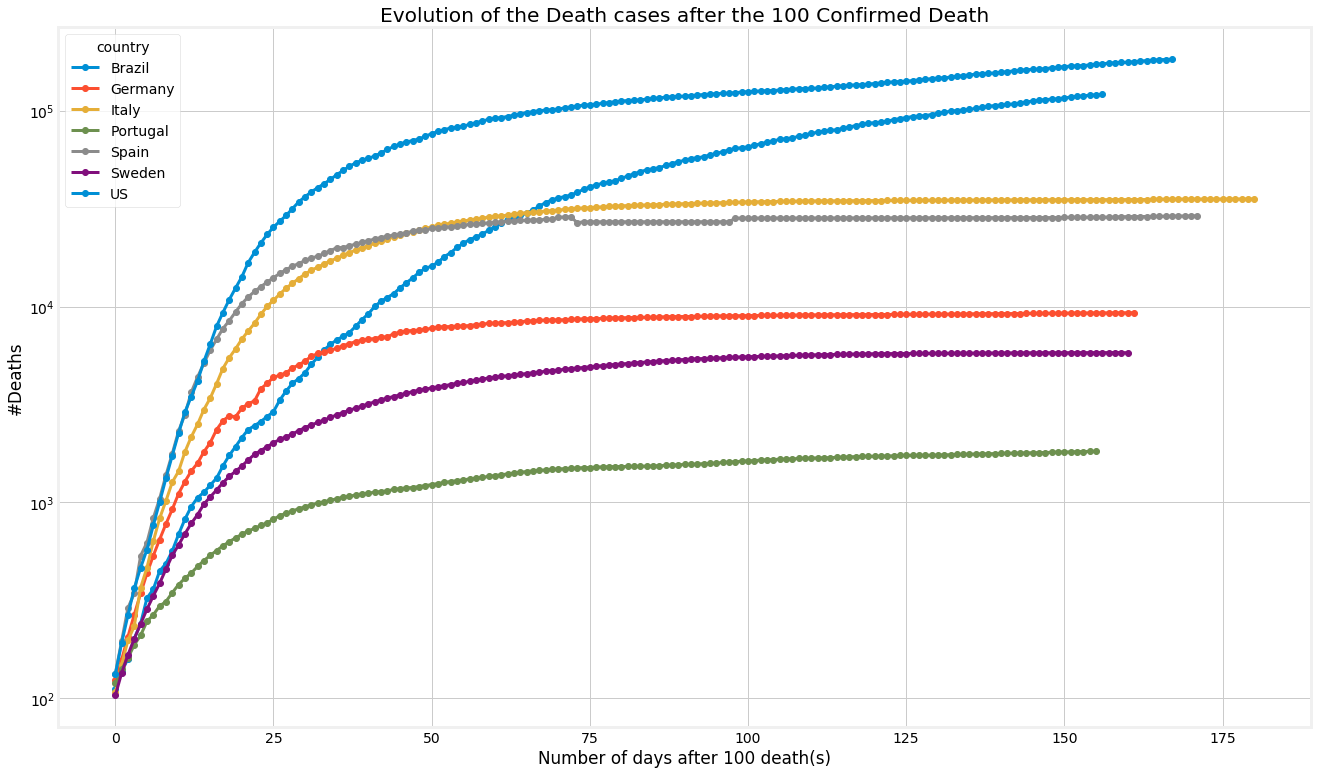

In [28]:
ax = df_deaths_by_country.drop('date', axis=1).plot(style='o-', logy=True)
ax.set_xlabel("Number of days after {0} death(s)".format(total_deaths))
ax.set_ylabel("#Deaths".format(total_deaths))
ax.set_title("Evolution of the Death cases after the {0} Confirmed Death".format(total_deaths))

Text(0, 0.5, '#Deaths')

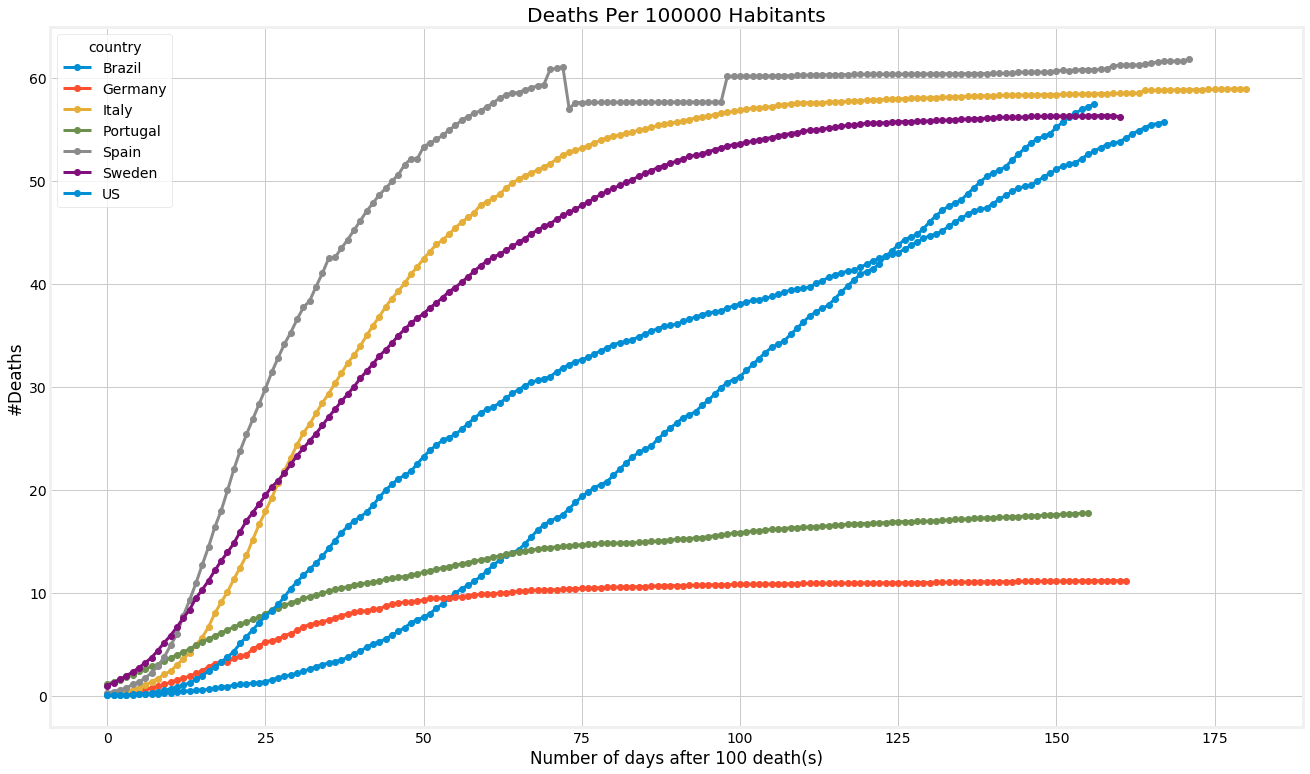

In [29]:
df_deaths_per_capita = df_deaths_by_country.copy()
df_deaths_per_capita.drop("date", axis=1, inplace=True)
for country in df_100_per_capita.columns:
      df_deaths_per_capita.loc[:,country] = (df_deaths_per_capita.loc[:,country] / populations.loc[country]["Population"]) * 10**5
ax = df_deaths_per_capita.plot(style='o-', title="Deaths Per 100000 Habitants", figsize=(20,12))
ax.set_xlabel("Number of days after {0} death(s)".format(total_deaths))
ax.set_ylabel("#Deaths")